## Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2

import glob
import os

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,Conv2D, Input, Flatten,Dropout,AveragePooling2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [3]:
import imutils
from imutils import face_utils

import dlib

# Data preparation

## Importing data

Testing and training sets are located in <code>./data</code> folder

In [4]:
train_mask = glob.glob('data/train/mask/*.jpg')
train_no_mask = glob.glob('data/train/no_mask/*.jpg')
test_mask = glob.glob('data/test/mask/*.jpg')
test_no_mask = glob.glob('data/test/no_mask/*.jpg')

## Spliting data into training, validation and testing sets

Shuffling both training and test sets

In [5]:
np.random.shuffle(train_mask)
np.random.shuffle(train_no_mask)

We also seperate out validation set from big training set, then prepare arrays with target classes

In [6]:
val_mask = train_mask[500:]
val_no_mask = train_mask[500:]

train_mask = train_mask[:500]
train_no_mask = train_no_mask[:500]

X_train = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in train_mask + train_no_mask])
y_train = np.array([label for label in ['mask'] * len(train_mask) + ['no_mask'] * len(train_no_mask)])

X_val = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in val_mask + val_no_mask])
y_val = np.array([label for label in ['mask'] * len(val_mask) + ['no_mask'] * len(val_no_mask)])

X_test = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in test_mask + test_no_mask])
y_test = np.array([label for label in ['mask'] * len(test_mask) + ['no_mask'] * len(test_no_mask)])

In [7]:
print('Set sizes: train: {}, val: {}, test: {}'.format(len(X_train), len(X_val), len(X_test)))

Set sizes: train: 1000, val: 308, test: 194


Example image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


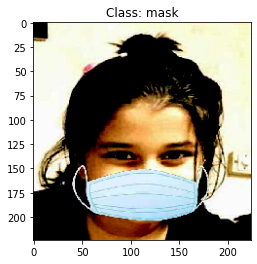

In [8]:
plt.imshow(X_train[77])
plt.title("Class: " + y_train[77])
plt.show()

## Preprocesing

We transform target class with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html'>OneHotEncoder</a>

In [9]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(y_train.reshape(-1,1))

y_train = ohe.transform(y_train.reshape(-1,1)).toarray()
y_val = ohe.transform(y_val.reshape(-1,1)).toarray()
y_test = ohe.transform(y_test.reshape(-1,1)).toarray()

# Image classification model

## Defining image data generator

<a href='https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator'>ImageDataGenerator</a> will be usful for fetching moderately transformed images during model's learning process

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Defining model structure

We use predefined <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2'>Tensorflows's MobileNetV2</a> architecture as basis of our model

**\<description\>**

In [19]:
model = keras.Sequential()
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [20]:
model.add(Input(shape=(224,224,3)))

model.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 32)      

In [22]:
INIT_LR = 1e-4 #initial learning rate
EPOCHS = 30 #number of epochs
BS = 32 # batch size

In [15]:
#, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()

In [23]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [24]:
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS,
    callbacks=[es])

Epoch 1/30
31/31 [==============================] - 26s 832ms/step - loss: 0.6096 - accuracy: 0.7035 - val_loss: 0.4075 - val_accuracy: 0.8918
Epoch 2/30
31/31 [==============================] - 27s 852ms/step - loss: 0.4451 - accuracy: 0.8244 - val_loss: 0.2299 - val_accuracy: 0.9381
Epoch 3/30
31/31 [==============================] - 26s 840ms/step - loss: 0.3592 - accuracy: 0.8688 - val_loss: 0.1592 - val_accuracy: 0.9485
Epoch 4/30
31/31 [==============================] - 26s 823ms/step - loss: 0.3106 - accuracy: 0.8822 - val_loss: 0.1291 - val_accuracy: 0.9691
Epoch 5/30
31/31 [==============================] - 27s 863ms/step - loss: 0.2636 - accuracy: 0.9122 - val_loss: 0.1071 - val_accuracy: 0.9588
Epoch 6/30
31/31 [==============================] - 27s 873ms/step - loss: 0.2677 - accuracy: 0.9050 - val_loss: 0.0997 - val_accuracy: 0.9742
Epoch 7/30
31/31 [==============================] - 27s 858ms/step - loss: 0.2603 - accuracy: 0.9132 - val_loss: 0.0837 - val_accuracy: 0.9742

In [25]:
model.save("mask_detector.model", save_format="h5")

In [26]:
predIdxs = model.predict(X_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=("mask","no_mask")))

              precision    recall  f1-score   support

        mask       0.97      1.00      0.98        97
     no_mask       1.00      0.97      0.98        97

    accuracy                           0.98       194
   macro avg       0.98      0.98      0.98       194
weighted avg       0.98      0.98      0.98       194



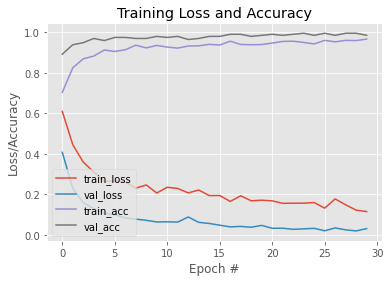

In [27]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [121]:
prototxtPath = os.path.sep.join(["deploy.prototxt.txt"])
weightsPath = os.path.sep.join(["res10_300x300_ssd_iter_140000.caffemodel"])

In [122]:
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [123]:
model = load_model("mask_detector.model")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [160]:
image = cv2.imread("./data_test/test14.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


In [161]:
def applyMask(l_img, box):
    startX, startY, endX, endY = box
    gray = cv2.cvtColor(l_img[startY:endY,startX:endX], cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects)==0:
        coords = np.array([[startX, (endY-startY) * 0.2],[(endX-startX) * 0.5,startY],[endX,(endY-startY) * 0.2]])
    else:
        shape = predictor(gray, rects[0])
        shape = face_utils.shape_to_np(shape)
        coords = shape[[0, 8, 16]]
    diff = coords[2] - coords[0]
    width = int(sum((diff) ** 2) ** (1/2))
    mid = (coords[0] + coords[2]) / 2
    angle = np.degrees(np.arctan2(diff[1], diff[0]))
    
    s_img = cv2.imread("./data/MASK2.png")
    s_img = imutils.resize(s_img, width=width)
    s_img = imutils.rotate_bound(s_img, angle)
    
    rows = [i for i, row in enumerate(s_img) if row.sum() == 0]
    columns = [i for i, col in enumerate(s_img.transpose(1, 0, 2)) if col.sum() == 0]

    s_img = np.delete(s_img, [rows], 0)
    s_img = np.delete(s_img.transpose(1, 0, 2), [columns], 0)
    s_img = s_img.transpose(1, 0, 2)

    if len(rects) != 0:
        x_offset=shape[51][0] - int(s_img.shape[1]/2)
        y_offset=shape[51][1] - int(s_img.shape[0]/2)
    else:
        x_offset = ((endX - startX)*0.5 - int(s_img.shape[1]/2))
        y_offset = ((endY - startY)*0.75 - int(s_img.shape[0]/2))
    
    y1, y2 = int(y_offset), int(y_offset) + s_img.shape[0]
    x1, x2 = int(x_offset), int(x_offset) + s_img.shape[1]

    y1 = max(0, y1)
    x1 = max(0, x1)
    y2 = min(l_img.shape[0]-1, y2)
    x2 = min(l_img.shape[1]-1, x2)
    
    for y in range(y1, y2):
        for x in range(x1, x2):
            l_img[y+startY, x+startX] = s_img[y-y1, x-x1] if sum(s_img[y-y1, x-x1]) != 0 else l_img[y+startY, x+startX]
    return l_img[startY:endY,startX:endX]

In [162]:
new_img = copy.deepcopy(image)
for i in range(0, detections.shape[2]):

    confidence = detections[0, 0, i, 2]

    if confidence > 0.50:

        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
        if np.abs(mask-withoutMask) < 0.2:
            label = "Indecisive"
            color = (0,255,255)
        else:
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        if withoutMask >= 0.6:
            applyMask(new_img, box.astype("int"))

        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

cv2.imshow("Output", image)
cv2.waitKey(0)
cv2.imshow("With Maska", new_img)
cv2.waitKey(0)

-1

# Bibliography

## Datasets

* https://data-flair.training/blogs/download-face-mask-data/
* https://www.kaggle.com/andrewmvd/face-mask-detection?select=annotations (for performence testing)